In [1]:
# Convex optimization HW3
import numpy as np
import numpy.linalg as npalg
import matplotlib.pyplot as plt
import math

# Part 1
def phi(x, t, Q, p, A, b):
    f = b - np.dot(A, x)
    barrier = - np.sum(np.log(f)) if np.all(f > 0) else math.inf
    return t * (0.5 * np.dot(x, np.dot(Q, x)) + np.dot(p, x)) + barrier

def grad(x, t, Q, p, A, b):
    phi = 1 / (b - np.dot(A, x))
    return t * (np.dot(Q, x) + p) + np.dot(A.T, phi)
    
def hess(x, t, Q, p, A, b):
    phi = 1 / (b - np.dot(A, x))
    return t * Q + np.dot(A.T, np.dot(np.diag(phi * phi), A))
    # return t * Q + np.dot(np.diag(phi * phi), np.dot(A, A.T))
    

def dampedNewtonStep(x, f, g, h):
    fx, gx, hx = f(x), g(x), h(x)
    #ihx = npalg.inv(hx)
    #dx = np.dot(ihx, gx)
    dx = npalg.solve(hx, gx)
    lx = np.dot(gx, dx)
    xnew = x - 1.0 / (1.0 + np.sqrt(lx)) * dx
    return xnew, lx / 2

def dampedNewton(x0, f, g, h, tol):
    x = x0
    xhist = []
    gap = math.inf
    while gap > tol:
        x, gap = dampedNewtonStep(x, f, g, h)
        xhist.append(x)
    return x, xhist

def newtonLSStep(x, f, g, h):
    fx, gx, hx = f(x), g(x), h(x)
    #ihx = npalg.inv(hx)
    #dx = np.dot(ihx, gx)
    dx = npalg.solve(hx, gx)
    lx = np.dot(gx, dx)
    
    #backtracking line search
    a, b = 0.1, 0.7
    t = 1.0
    wx = np.dot(gx, dx)
    while f(x - t * dx) > fx - a*t*wx:
        t *= b    
        
    return x - t * dx, lx / 2

def newtonLS(x0, f, g, h, tol):
    x = x0
    xhist = []
    gap = math.inf
    while gap > tol:
        x, gap = newtonLSStep(x, f, g, h)
        xhist.append(x)
    return x, xhist


In [2]:
def initialize_svm_primal(tau, X, y):
    n, d = X.shape
    x0 = np.hstack((np.zeros(d), 1.1 * np.ones(n)))
    return x0

def transform_svm_primal(tau, X, y):
    n, d = X.shape
    
    Q = np.zeros((n + d, n + d))
    Q[:d, :d] = np.identity(d)
    
    p = np.hstack((np.zeros(d), np.ones(n) / (tau * n)))
    
    A = np.zeros((2 * n, d + n))
    A[0:n  , 0:d] = - X * y[:, None]
    A[0:n  , d:d+n] = -np.identity(n)
    #A[n:2*n, 0:d] = np.zeros((n, d))
    A[n:, d:] = -np.identity(n)
    
    b = np.hstack((-np.ones(n), np.zeros(n)))
    
    return Q, p, A, b

def initialize_svm_dual(tau, X, y):
    n, d = X.shape
    x0 = np.ones(n) / (2 * tau * n)
    return x0

def transform_svm_dual(tau, X, y):
    n, d = X.shape
    
    S = X * y[:, None]
    Q = np.dot(S, S.T)
    
    p = -np.ones(n)
    
    A = np.zeros((2 * n, n))
    A[:n, :] = - np.identity(n)
    A[n:, :] = np.identity(n)

    b = np.hstack((np.zeros(n), np.ones(n) / (tau * n)))
    
    return Q, p, A, b

def barr_method(Q, p, A, b, x0, mu, tol):
    m = len(b)
    xhist = []
    x = x0
    t = 1
    while True:
        # We need to re-evaluate each time
        # for the modification of t
        f = lambda x : phi(x, t, Q, p, A, b)
        g = lambda x : grad(x, t, Q, p, A, b)
        h = lambda x : hess(x, t, Q, p, A, b)
        
        x, nhist = newtonLS(x, f, g, h, tol)
        xhist.append(x)
        if m < t * tol:
            break
        t *= mu    
    
    return x, np.array(xhist)

In [3]:
# Calculate 2 points defining a line given
# a normal vector and bounds
def get_line_points(W, Xs, Ys):
    if (W[0]):
        return [(- W[1] * Ys[0] - W[2]) / W[0], (- W[1] * Ys[1] - W[2]) / W[0]], [Ys[0], Ys[1]]
    elif (W[1]):
        return [Xs[0], Xs[1]],[(- W[0] * Xs[0] - W[2]) / W[1], (- W[0] * Xs[1] - W[2]) / W[1]]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def rot(t):
    return np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

def generate_points(mu0, mu1, dsigma0, dsigma1, rotsigma0, rotsigma1, N0, N1):
    
    sigma0 = rot(rotsigma0).dot(np.diag(dsigma0)).dot(rot(-rotsigma0))
    sigma1 = rot(rotsigma1).dot(np.diag(dsigma1)).dot(rot(-rotsigma1))

    data0 = np.random.multivariate_normal(mu0, sigma0, N0)
    data1 = np.random.multivariate_normal(mu1, sigma1, N1)

    X = np.vstack((data0, data1))
    y = np.hstack((-np.ones(N0), np.ones(N1)))

    # Add a column of ones
    X = np.hstack((X, np.ones(N0 + N1)[:, None]))
    
    return X, y
    

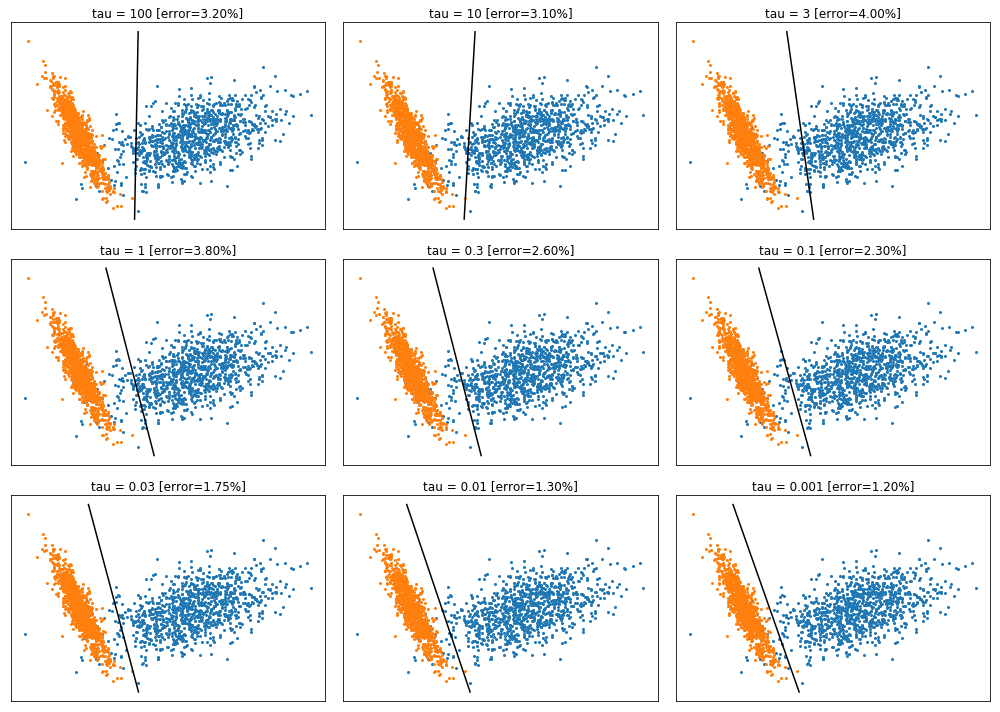

In [5]:
mu0 = np.array([2.5, 0])
mu1 = np.array([-2.5, 0])
dsigma0 = np.array([4, 1.5])
dsigma1 = np.array([0.07, 4.5])
rotsigma0 = np.pi / 4
rotsigma1 = np.pi / 12

X_train, y_train = generate_points(mu0, mu1, dsigma0, dsigma1, rotsigma0, rotsigma1, 200, 200)
#X_test, y_test = X_train, y_train
# If you don't want the test data to be the same as the train data
X_test, y_test = generate_points(mu0, mu1, dsigma0, dsigma1, rotsigma0, rotsigma1, 1000, 1000)

n, d = X_train.shape
mu = 10
tol = 0.001

taus = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100]

plt.figure(figsize=(14, 10))
for i, tau in enumerate(reversed(taus)):
        Q, p, A, b = transform_svm_primal(tau, X_train, y_train)
        x0 = initialize_svm_primal(tau, X_train, y_train)

        x, xhist = barr_method(Q, p, A, b, x0, mu,tol)
        
        w = x[:d]
        
        prediction = np.where(np.dot(X_test, w) < 0, -1, 1)
        error = np.sum((prediction * y_test) == -1) / len(y_test)
        
        plt.subplot(3, 3, i+1)
        plt.scatter(*X_test[y_test == -1, :2].T, 4)
        plt.scatter(*X_test[y_test ==  1, :2].T, 4)

        lx, ly = get_line_points(w, plt.xlim(), plt.ylim())
        
        plt.yticks([])
        plt.xticks([])
        plt.title("tau = %g [error=%.2f%%]" % (tau, error * 100))
        plt.plot(lx, ly, c='k')

plt.tight_layout()
#plt.savefig("../../imgs/gmm_tau.pdf")
plt.show()

In [6]:
import random

# Load Iris dataset
def converter(flower):
    if flower == b'Iris-versicolor':
        return -1
    elif flower == b'Iris-virginica':
        return 1
    elif flower == b'Iris-setosa':
        return np.nan

def load_iris(src):
    iris = np.loadtxt(src, delimiter=",", converters = {4: converter})
    iris = iris[~np.isnan(iris[:,-1])]
    iris_class = iris[:, -1].copy()
    iris_features = iris
    iris_features[:, -1] = 1
    return iris_features, iris_class

# Take a random number of samples
def sample(features, values, prob):
    select = np.random.binomial(1, prob, len(features))
    select = np.where(select == 1, True, False)
    X = features[select]
    y = values[select]
    return X, y

def train_iris_primal(iris_features, iris_class, pct, tau, mu, tol):
    X, y = sample(iris_features, iris_class, pct)

    n, d = X.shape
    Q, p, A, b = transform_svm_primal(tau, X, y)
    x0 = initialize_svm_primal(tau, X, y)

    return barr_method(Q, p, A, b, x0, mu, tol)

def train_iris_dual(iris_features, iris_class, pct, tau, mu, tol):
    X, y = sample(iris_features, iris_class, pct)
    n, d = X.shape

    Q, p, A, b = transform_svm_dual(tau, X, y)
    x0 = initialize_svm_dual(tau, X, y)
    
    return barr_method(Q, p, A, b, x0, mu, tol)


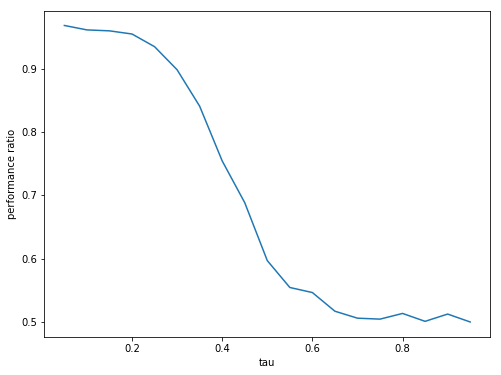

In [7]:
pct = 0.8  # Determines the number of flower selected for training
tau = 0.01
mu = 10
tol = 0.001

iris_features, iris_class = load_iris("data/iris.data")

rangz = np.arange(0.05, 1, 0.05)
ratios = np.zeros(len(rangz))

M = 20
for j in range(M):
    for i, tau in enumerate(rangz):
        x, xhist = train_iris_primal(iris_features, iris_class, pct, tau, mu, tol)
        w = x[:5]

        predicted = np.where(np.dot(iris_features, w) < 0, -1, 1)
        ratio = np.sum(predicted * iris_class == 1) / len(iris_class)
        ratios[i] += ratio

        #print("performance [p=%.2f, mu=%.2f, tau=%.2f, tol=%.3f] : %.2f%%" % (pct, mu, tau, tol, ratio * 100))


plt.figure(figsize=(8, 6))
plt.plot(rangz, ratios / M)
plt.xlabel("tau")
plt.ylabel("performance ratio")
#plt.savefig("../../imgs/iris.pdf")
plt.show()



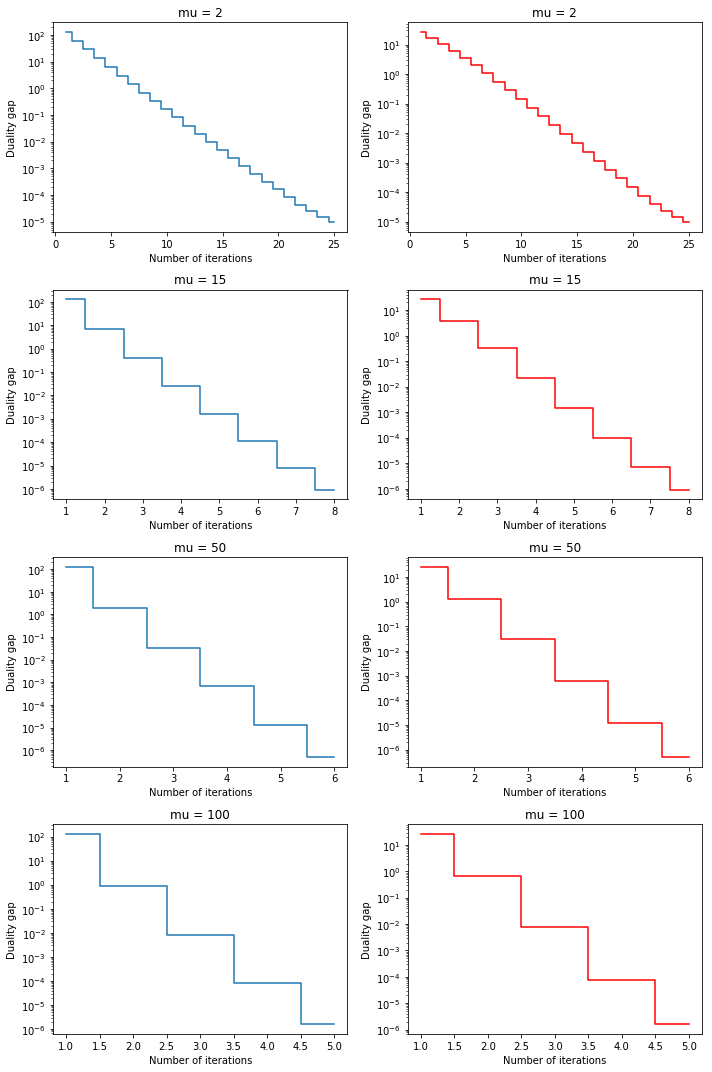

In [8]:
# Plotting duality gap

pct = 0.8  # Determines the number of flower selected for training
tau = 0.01
mu = 1.5
tol = 0.00001

iris_features, iris_class = load_iris("data/iris.data")
X, y = sample(iris_features, iris_class, pct)

n, d = X.shape

plt.figure(figsize=(10, 15))
for i, mu in enumerate([2, 15, 50, 100]):
    
    # Barrier method to find a primal solution
    Q_p, p_p, A_p, b_p = transform_svm_primal(tau, X, y)
    x0_p = initialize_svm_primal(tau, X, y)

    x_p, x_p_hist = barr_method(Q_p, p_p, A_p, b_p, x0_p, mu, tol)

    # Barrier method to find a dual solution

    Q_d, p_d, A_d, b_d = transform_svm_dual(tau, X, y)
    x0_d = initialize_svm_dual(tau, X, y)

    x_d, x_d_hist = barr_method(Q_d, p_d, A_d, b_d, x0_d, mu, tol)

    # Calculate the values
    fp_xhist = (np.sum(x_p_hist[:, d:], axis=1) / (tau * n) +
                np.sum(x_p_hist[:, :d] * x_p_hist[:, :d], axis=1) / 2)

    D = np.sum((x_d_hist*y)[:,:,None] * X[None, :, :], axis=1)
    fd_xhist = (np.sum(x_d_hist, axis=1) -
                np.sum(D * D, axis=1) / 2)

    rangefp = np.arange(1, len(fp_xhist) + 1)
    rangefd = np.arange(1, len(fd_xhist) + 1)

    plt.subplot(4, 2, 2 * i + 1)
    plt.step(rangefp, fp_xhist - fd_xhist[-1], where='mid')
    plt.gca().set_yscale('log')
    plt.title("mu = " + str(mu))
    plt.xlabel("Number of iterations")
    plt.ylabel("Duality gap")


    plt.subplot(4, 2, 2 * i + 2)
    plt.step(rangefd, fp_xhist[-1] - fd_xhist, where='mid', color='red')
    plt.gca().set_yscale('log')
    plt.title("mu = " + str(mu))
    plt.xlabel("Number of iterations")
    plt.ylabel("Duality gap")


plt.tight_layout()
#plt.savefig("../../imgs/duality_gaps.pdf")
plt.show()
